Import All Packages

In [1]:
import pandas as pd
import numpy as np
import time

import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)
from matplotlib.pyplot import cm
%matplotlib inline

from sklearn.manifold import TSNE

from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
# from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import roc_auc_score, accuracy_score
# from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE

C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load All Data

In [2]:
def load_data(maxLines, duplicates):

    """
        Import datasets, select features and define the default-flag collumn.
    """
    
    col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
            'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
            'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
            'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']
    
    extended_selec_acq = ['LoanID', 'OrLTV', 'LoanPurpose', 'DTIRat', 'PropertyType', 'FTHomeBuyer', 'Channel', 'SellerName','OrInterestRate', 'CreditScore', 'NumBorrow', 'OrDate'] 
    col_acq_subset = extended_selec_acq 
    
    col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
              'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
              'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
              'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
              'FPWA','ServicingIndicator'] 
    
    extended_selec_per = ['LoanID', 'MonthsToMaturity', 'CurrInterestRate', 'ForeclosureDate', 'LoanAge', 'CLDS', 'MaturityDate','ZeroBalCode', 'MonthRep']
    
    col_per_subset =  extended_selec_per 
    
    lines_to_read = maxLines
    aquisition_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Acquisition_2007Q4.txt', sep='|', names=col_acq, usecols=col_acq_subset, index_col=False, nrows=lines_to_read )
    performance_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Performance_2007Q4.txt', sep='|', names=col_per, usecols=col_per_subset, index_col=False, nrows=lines_to_read) 

    """ Fix the IDs in the observation set by fixing their reporting date AND requiring that the files are healthy. """
    
    observation_frame = performance_frame[(performance_frame.MonthRep == '12/01/2017') & 
                                (   (performance_frame.CLDS == '0') | 
                                    (performance_frame.CLDS == '1') | 
                                    (performance_frame.CLDS == '2')
                                )
                                ]
    obs_ids = observation_frame.LoanID
    
    """ Load only the observation IDs in the performance frame initially. """
    pf = performance_frame[performance_frame.LoanID.isin(obs_ids)]
    
    """ Keep only the reporting dates that are in our performance period (MM/DD/YYYY format). """
    pf_obs = pf[
                    (pf.MonthRep == '01/01/2018') | 
                    (pf.MonthRep == '02/01/2018') |
                    (pf.MonthRep == '03/01/2018') |
                    (pf.MonthRep == '04/01/2018') |
                    (pf.MonthRep == '05/01/2018') |
                    (pf.MonthRep == '06/01/2018') |
                    (pf.MonthRep == '07/01/2018') |
                    (pf.MonthRep == '08/01/2018') |
                    (pf.MonthRep == '09/01/2018') |
                    (pf.MonthRep == '10/01/2018') |
                    (pf.MonthRep == '11/01/2018') |
                    (pf.MonthRep == '12/01/2018') 
                ]
    
    """ 
    Find the LoanIDs of those loans where a default appears in our performance period.
    """
    pf_obs_defaults = pf_obs[
                            (pf_obs.CLDS != '0') &
                            (pf_obs.CLDS != '1') &
                            (pf_obs.CLDS != '2') &
                            (pf_obs.CLDS != 'X')
                        ].LoanID
    
    pf_obs_defaults.drop_duplicates(keep='last', inplace=True)
    
    """ Merge the acquisition and performance frames. """
    df = pd.merge(aquisition_frame, observation_frame, on = 'LoanID', how='inner')
    
    df['Default'] = 0
    df.loc[df['LoanID'].isin(pf_obs_defaults), 'Default'] = 1
    
    
    return df

In [3]:
def make_target_var(df):
    df.rename(index=str, columns={'ForeclosureDate': 'Default'}, inplace= True)
    df['Default'].fillna(0, inplace=True)
    df.loc[df['Default'] != 0, 'Default'] = 1

In [4]:
def get_na_columns(df):
    na_columns = df.columns[df.isnull().any()]
    return na_columns

In [5]:
def get_cat_feat(df):
    cat_feat = df.select_dtypes(include=['object']).columns
    return cat_feat

def get_num_feat(df):
    num_feat = df.select_dtypes(exclude=['object']).columns
    return num_feat

In [6]:
def normalize(df):
    df_norm = df
    df_norm = df_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df_norm

In [7]:
def makeDateNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[3:7])
    result = (numYears - 2000) * 12 + numMonths
    return result


def makeDayNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[6:10])
    result = (numYears - 2000) * 12 + numMonths
    return result

def make_dates_numeric(df):
    # TRANSFORM DATES TO NUMBER OF MONTHS (STARTING FROM 01/2000)
    df['MonthRep'] = df['MonthRep'].apply(makeDayNumeric)
    df['OrDate'] = df['OrDate'].apply(makeDateNumeric)
    df['FirstPayment'] = df['FirstPayment'].apply(makeDateNumeric)
    df['MaturityDate'] = df['MaturityDate'].apply(makeDateNumeric)

In [8]:
def to_2D(df):
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df)
    df_2D = pd.DataFrame(df_2D)
    return df_2D

In [9]:
def tsne_visual(df):   
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df.drop('Default', axis=1))
    df_2D = pd.DataFrame(df_2D)
    
    
    #Making plot
    plt.figure(figsize=(20,10))
    color = cm.rainbow(np.linspace(0,1, max(map(abs, set(df['Default'])))+1))
    for i in range(0, len(df_2D)):
        c1 = plt.scatter(df_2D.iloc[i][0], 
                         df_2D.iloc[i][1],
                     c = color[int(df.iloc[i]['Default'])],
                     marker=r"$ {} $".format(int(df.iloc[i]['Default'])), s=150, edgecolors='none')

    plt.xlabel('T-SNE Dim 1')
    plt.ylabel('T-SNE Dim 2')
    plt.title('Actives')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('Actives' + '.pdf', format='pdf', dpi=900)
    plt.show()

MAIN

In [10]:
df = load_data(100000, False)
# make_dates_numeric(df)

# FORCE FEATURES TO BE INCLUDED
df = df[pd.notnull(df['CreditScore'])]
# df = df[pd.notnull(df['CLDS'])]
df = df[pd.notnull(df['DTIRat'])]

# FORCE FEATURES TO BE EXCLUDED
df = df.drop('LoanID',axis=1)

# FORCE FEATURE TO BE CATEGORICAL
# df['Zip'] = df['Zip'].astype('object',copy=False)
# df['MSA'] = df['MSA'].astype('object',copy=False)


na_columns = get_na_columns(df)
df = df.drop(na_columns,axis=1)

cat_feat = get_cat_feat(df)
cat_data = df[cat_feat]
# cat_data = cat_data.apply(LabelEncoder().fit_transform)

num_feat = get_num_feat(df)
num_data = normalize(df[num_feat])

df = pd.concat([num_data, cat_data], axis=1)
print(df.columns)

Index(['OrInterestRate', 'OrLTV', 'NumBorrow', 'DTIRat', 'CreditScore',
       'CurrInterestRate', 'LoanAge', 'MonthsToMaturity', 'Default', 'Channel',
       'SellerName', 'OrDate', 'FTHomeBuyer', 'LoanPurpose', 'PropertyType',
       'MonthRep', 'MaturityDate', 'CLDS'],
      dtype='object')


MAIN 2

In [11]:
"""
    Split the target variable from the input variables.
""" 
y = df['Default']
X = df.drop(['Default'], axis=1)

In [12]:
print(y.value_counts())

0.0    144
1.0     16
Name: Default, dtype: int64


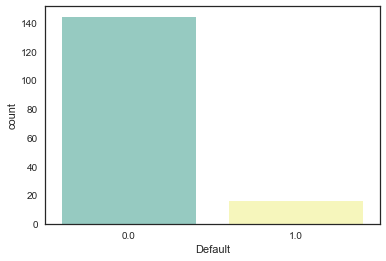

In [13]:
ax = sns.countplot(x="Default", data=df, palette = "Set3")

In [14]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

Before OverSampling, counts of label '1': 16
Before OverSampling, counts of label '0': 144 



In [15]:
#Perform Upsampling Using SMOTE
from imblearn.over_sampling import SMOTENC
categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)

print('After OverSampling, the shape of X: {}'.format(X_res.shape))
print('After OverSampling, the shape of y: {} \n'.format(y_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_res==0)))

[ 8  9 10 11 12 13 14 15 16]


ValueError: could not convert string to float: 'B'

In [16]:
"""
    Balance classes with Synthetic Minority Oversampling Technique (SMOTE) or Random Undersampling.
    Choose here either sampling_method = "Random Under Sampling" or "SMOTE". 
    Save n_1 and n_0 separately to apply a correction to the resampling when using the model to predict.
"""     

n_1 = sum(y)
n_0 = len(y) - sum(y)

sm = SMOTE()

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts())

ValueError: could not convert string to float: 'B'

In [17]:
# X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = np.array([0, 0, 1, 1])
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [19]:
sm = SMOTE()

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts())

ValueError: could not convert string to float: 'B'

In [14]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]
categorical_features_indices

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int64)

In [15]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [16]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [20]:
for train_index, test_index in skf.split(X, y):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # fit model on training data
    model.fit(
        X_train, y_train,
        cat_features=cat_feat,
        eval_set=(X_test, y_test), 
        logging_level='Verbose',  # you can uncomment this for text output
        plot=True);

Learning rate set to 0.063615
0:	learn: 0.6156074	test: 0.6207568	best: 0.6207568 (0)	total: 217ms	remaining: 3m 37s
1:	learn: 0.5708240	test: 0.5799155	best: 0.5799155 (1)	total: 243ms	remaining: 2m 1s
2:	learn: 0.5130471	test: 0.5314544	best: 0.5314544 (2)	total: 277ms	remaining: 1m 31s
3:	learn: 0.4826391	test: 0.5060263	best: 0.5060263 (3)	total: 328ms	remaining: 1m 21s
4:	learn: 0.4379939	test: 0.4695940	best: 0.4695940 (4)	total: 384ms	remaining: 1m 16s
5:	learn: 0.4163249	test: 0.4513882	best: 0.4513882 (5)	total: 430ms	remaining: 1m 11s
6:	learn: 0.3758813	test: 0.4347513	best: 0.4347513 (6)	total: 493ms	remaining: 1m 9s
7:	learn: 0.3458100	test: 0.4219264	best: 0.4219264 (7)	total: 566ms	remaining: 1m 10s


8:	learn: 0.3342877	test: 0.4128431	best: 0.4128431 (8)	total: 597ms	remaining: 1m 5s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

9:	learn: 0.3100012	test: 0.4076092	best: 0.4076092 (9)	total: 741ms	remaining: 1m 13s
10:	learn: 0.2920211	test: 0.3999852	best: 0.3999852 (10)	total: 835ms	remaining: 1m 15s
11:	learn: 0.2753413	test: 0.3992607	best: 0.3992607 (11)	total: 997ms	remaining: 1m 22s
12:	learn: 0.2621654	test: 0.3964981	best: 0.3964981 (12)	total: 1.06s	remaining: 1m 20s
13:	learn: 0.2478674	test: 0.3924198	best: 0.3924198 (13)	total: 1.14s	remaining: 1m 20s
14:	learn: 0.2380885	test: 0.3888015	best: 0.3888015 (14)	total: 1.22s	remaining: 1m 20s
15:	learn: 0.2353185	test: 0.3879884	best: 0.3879884 (15)	total: 1.25s	remaining: 1m 17s
16:	learn: 0.2287384	test: 0.3891756	best: 0.3879884 (15)	total: 1.3s	remaining: 1m 14s
17:	learn: 0.2267436	test: 0.3888941	best: 0.3879884 (15)	total: 1.32s	remaining: 1m 11s
18:	learn: 0.2205516	test: 0.3914438	best: 0.3879884 (15)	total: 1.36s	remaining: 1m 10s
19:	learn: 0.2157924	test: 0.3917746	best: 0.3879884 (15)	total: 1.39s	remaining: 1m 8s
20:	learn: 0.2109415	test

104:	learn: 0.0831574	test: 0.4536487	best: 0.3879884 (15)	total: 7.44s	remaining: 1m 3s
105:	learn: 0.0813119	test: 0.4516071	best: 0.3879884 (15)	total: 7.54s	remaining: 1m 3s
106:	learn: 0.0809250	test: 0.4532187	best: 0.3879884 (15)	total: 7.62s	remaining: 1m 3s
107:	learn: 0.0792307	test: 0.4621523	best: 0.3879884 (15)	total: 7.7s	remaining: 1m 3s
108:	learn: 0.0781358	test: 0.4675496	best: 0.3879884 (15)	total: 7.78s	remaining: 1m 3s
109:	learn: 0.0760049	test: 0.4682238	best: 0.3879884 (15)	total: 7.88s	remaining: 1m 3s
110:	learn: 0.0732269	test: 0.4766690	best: 0.3879884 (15)	total: 8s	remaining: 1m 4s
111:	learn: 0.0707413	test: 0.4810928	best: 0.3879884 (15)	total: 8.14s	remaining: 1m 4s
112:	learn: 0.0702635	test: 0.4798981	best: 0.3879884 (15)	total: 8.22s	remaining: 1m 4s
113:	learn: 0.0685148	test: 0.4833187	best: 0.3879884 (15)	total: 8.32s	remaining: 1m 4s
114:	learn: 0.0683196	test: 0.4815101	best: 0.3879884 (15)	total: 8.41s	remaining: 1m 4s
115:	learn: 0.0668947	tes

198:	learn: 0.0207196	test: 0.5389874	best: 0.3879884 (15)	total: 17.2s	remaining: 1m 9s
199:	learn: 0.0204664	test: 0.5393769	best: 0.3879884 (15)	total: 17.3s	remaining: 1m 9s
200:	learn: 0.0202569	test: 0.5408779	best: 0.3879884 (15)	total: 17.4s	remaining: 1m 9s
201:	learn: 0.0200654	test: 0.5425065	best: 0.3879884 (15)	total: 17.5s	remaining: 1m 9s
202:	learn: 0.0197765	test: 0.5447780	best: 0.3879884 (15)	total: 17.6s	remaining: 1m 9s
203:	learn: 0.0194876	test: 0.5460408	best: 0.3879884 (15)	total: 17.7s	remaining: 1m 9s
204:	learn: 0.0192595	test: 0.5468671	best: 0.3879884 (15)	total: 17.9s	remaining: 1m 9s
205:	learn: 0.0191661	test: 0.5473635	best: 0.3879884 (15)	total: 17.9s	remaining: 1m 9s
206:	learn: 0.0189874	test: 0.5468801	best: 0.3879884 (15)	total: 18s	remaining: 1m 9s
207:	learn: 0.0188200	test: 0.5478937	best: 0.3879884 (15)	total: 18.1s	remaining: 1m 9s
208:	learn: 0.0186595	test: 0.5482566	best: 0.3879884 (15)	total: 18.3s	remaining: 1m 9s
209:	learn: 0.0185761	t

291:	learn: 0.0101335	test: 0.6145982	best: 0.3879884 (15)	total: 26s	remaining: 1m 2s
292:	learn: 0.0100986	test: 0.6150529	best: 0.3879884 (15)	total: 26.1s	remaining: 1m 2s
293:	learn: 0.0100534	test: 0.6157639	best: 0.3879884 (15)	total: 26.2s	remaining: 1m 2s
294:	learn: 0.0099875	test: 0.6178089	best: 0.3879884 (15)	total: 26.3s	remaining: 1m 2s
295:	learn: 0.0099377	test: 0.6180785	best: 0.3879884 (15)	total: 26.4s	remaining: 1m 2s
296:	learn: 0.0098780	test: 0.6192634	best: 0.3879884 (15)	total: 26.5s	remaining: 1m 2s
297:	learn: 0.0098345	test: 0.6211075	best: 0.3879884 (15)	total: 26.6s	remaining: 1m 2s
298:	learn: 0.0097819	test: 0.6213713	best: 0.3879884 (15)	total: 26.7s	remaining: 1m 2s
299:	learn: 0.0097514	test: 0.6217093	best: 0.3879884 (15)	total: 26.8s	remaining: 1m 2s
300:	learn: 0.0096921	test: 0.6222741	best: 0.3879884 (15)	total: 26.9s	remaining: 1m 2s
301:	learn: 0.0096321	test: 0.6228819	best: 0.3879884 (15)	total: 27s	remaining: 1m 2s
302:	learn: 0.0095958	tes

385:	learn: 0.0065539	test: 0.6700293	best: 0.3879884 (15)	total: 35s	remaining: 55.6s
386:	learn: 0.0065081	test: 0.6704836	best: 0.3879884 (15)	total: 35.1s	remaining: 55.5s
387:	learn: 0.0064631	test: 0.6706663	best: 0.3879884 (15)	total: 35.2s	remaining: 55.5s
388:	learn: 0.0064396	test: 0.6705773	best: 0.3879884 (15)	total: 35.3s	remaining: 55.4s
389:	learn: 0.0064231	test: 0.6708171	best: 0.3879884 (15)	total: 35.4s	remaining: 55.3s
390:	learn: 0.0064086	test: 0.6714140	best: 0.3879884 (15)	total: 35.5s	remaining: 55.2s
391:	learn: 0.0063754	test: 0.6719434	best: 0.3879884 (15)	total: 35.6s	remaining: 55.1s
392:	learn: 0.0063531	test: 0.6734452	best: 0.3879884 (15)	total: 35.6s	remaining: 55.1s
393:	learn: 0.0063194	test: 0.6731823	best: 0.3879884 (15)	total: 35.8s	remaining: 55s
394:	learn: 0.0062848	test: 0.6734050	best: 0.3879884 (15)	total: 35.9s	remaining: 54.9s
395:	learn: 0.0062748	test: 0.6735282	best: 0.3879884 (15)	total: 36s	remaining: 54.9s
396:	learn: 0.0062367	test:

480:	learn: 0.0047104	test: 0.7069253	best: 0.3879884 (15)	total: 44.2s	remaining: 47.7s
481:	learn: 0.0046979	test: 0.7074172	best: 0.3879884 (15)	total: 44.3s	remaining: 47.6s
482:	learn: 0.0046808	test: 0.7072361	best: 0.3879884 (15)	total: 44.4s	remaining: 47.6s
483:	learn: 0.0046681	test: 0.7072217	best: 0.3879884 (15)	total: 44.5s	remaining: 47.4s
484:	learn: 0.0046586	test: 0.7076923	best: 0.3879884 (15)	total: 44.6s	remaining: 47.4s
485:	learn: 0.0046459	test: 0.7079376	best: 0.3879884 (15)	total: 44.7s	remaining: 47.3s
486:	learn: 0.0046390	test: 0.7081253	best: 0.3879884 (15)	total: 44.8s	remaining: 47.2s
487:	learn: 0.0046176	test: 0.7084328	best: 0.3879884 (15)	total: 45s	remaining: 47.2s
488:	learn: 0.0046028	test: 0.7081309	best: 0.3879884 (15)	total: 45.1s	remaining: 47.1s
489:	learn: 0.0045937	test: 0.7082917	best: 0.3879884 (15)	total: 45.2s	remaining: 47.1s
490:	learn: 0.0045791	test: 0.7086392	best: 0.3879884 (15)	total: 45.3s	remaining: 47s
491:	learn: 0.0045628	tes

573:	learn: 0.0036028	test: 0.7381208	best: 0.3879884 (15)	total: 53.2s	remaining: 39.5s
574:	learn: 0.0035910	test: 0.7384018	best: 0.3879884 (15)	total: 53.4s	remaining: 39.4s
575:	learn: 0.0035798	test: 0.7388572	best: 0.3879884 (15)	total: 53.5s	remaining: 39.4s
576:	learn: 0.0035739	test: 0.7390820	best: 0.3879884 (15)	total: 53.6s	remaining: 39.3s
577:	learn: 0.0035690	test: 0.7391307	best: 0.3879884 (15)	total: 53.7s	remaining: 39.2s
578:	learn: 0.0035647	test: 0.7393530	best: 0.3879884 (15)	total: 53.8s	remaining: 39.1s
579:	learn: 0.0035533	test: 0.7394873	best: 0.3879884 (15)	total: 53.9s	remaining: 39s
580:	learn: 0.0035440	test: 0.7403632	best: 0.3879884 (15)	total: 54s	remaining: 38.9s
581:	learn: 0.0035357	test: 0.7404378	best: 0.3879884 (15)	total: 54.1s	remaining: 38.8s
582:	learn: 0.0035265	test: 0.7416379	best: 0.3879884 (15)	total: 54.2s	remaining: 38.8s
583:	learn: 0.0035199	test: 0.7418921	best: 0.3879884 (15)	total: 54.3s	remaining: 38.7s
584:	learn: 0.0035165	tes

666:	learn: 0.0029323	test: 0.7665632	best: 0.3879884 (15)	total: 1m 2s	remaining: 31.1s
667:	learn: 0.0029255	test: 0.7663362	best: 0.3879884 (15)	total: 1m 2s	remaining: 31.1s
668:	learn: 0.0029206	test: 0.7665850	best: 0.3879884 (15)	total: 1m 2s	remaining: 31s
669:	learn: 0.0029169	test: 0.7673537	best: 0.3879884 (15)	total: 1m 2s	remaining: 30.9s
670:	learn: 0.0029119	test: 0.7676567	best: 0.3879884 (15)	total: 1m 2s	remaining: 30.8s
671:	learn: 0.0029047	test: 0.7681830	best: 0.3879884 (15)	total: 1m 2s	remaining: 30.7s
672:	learn: 0.0028904	test: 0.7682005	best: 0.3879884 (15)	total: 1m 3s	remaining: 30.6s
673:	learn: 0.0028822	test: 0.7680429	best: 0.3879884 (15)	total: 1m 3s	remaining: 30.5s
674:	learn: 0.0028738	test: 0.7680889	best: 0.3879884 (15)	total: 1m 3s	remaining: 30.5s
675:	learn: 0.0028682	test: 0.7683794	best: 0.3879884 (15)	total: 1m 3s	remaining: 30.3s
676:	learn: 0.0028599	test: 0.7683893	best: 0.3879884 (15)	total: 1m 3s	remaining: 30.2s
677:	learn: 0.0028553	t

759:	learn: 0.0024728	test: 0.7864417	best: 0.3879884 (15)	total: 1m 11s	remaining: 22.5s
760:	learn: 0.0024684	test: 0.7862720	best: 0.3879884 (15)	total: 1m 11s	remaining: 22.4s
761:	learn: 0.0024662	test: 0.7866450	best: 0.3879884 (15)	total: 1m 11s	remaining: 22.3s
762:	learn: 0.0024614	test: 0.7868351	best: 0.3879884 (15)	total: 1m 11s	remaining: 22.2s
763:	learn: 0.0024574	test: 0.7868149	best: 0.3879884 (15)	total: 1m 11s	remaining: 22.2s
764:	learn: 0.0024544	test: 0.7873343	best: 0.3879884 (15)	total: 1m 11s	remaining: 22.1s
765:	learn: 0.0024513	test: 0.7876713	best: 0.3879884 (15)	total: 1m 11s	remaining: 22s
766:	learn: 0.0024455	test: 0.7879903	best: 0.3879884 (15)	total: 1m 11s	remaining: 21.9s
767:	learn: 0.0024380	test: 0.7884005	best: 0.3879884 (15)	total: 1m 12s	remaining: 21.8s
768:	learn: 0.0024345	test: 0.7884941	best: 0.3879884 (15)	total: 1m 12s	remaining: 21.7s
769:	learn: 0.0024324	test: 0.7885544	best: 0.3879884 (15)	total: 1m 12s	remaining: 21.6s
770:	learn: 

853:	learn: 0.0021206	test: 0.8060430	best: 0.3879884 (15)	total: 1m 20s	remaining: 13.7s
854:	learn: 0.0021175	test: 0.8059622	best: 0.3879884 (15)	total: 1m 20s	remaining: 13.7s
855:	learn: 0.0021120	test: 0.8061231	best: 0.3879884 (15)	total: 1m 20s	remaining: 13.6s
856:	learn: 0.0021090	test: 0.8063801	best: 0.3879884 (15)	total: 1m 20s	remaining: 13.5s
857:	learn: 0.0021061	test: 0.8065726	best: 0.3879884 (15)	total: 1m 20s	remaining: 13.4s
858:	learn: 0.0021044	test: 0.8067455	best: 0.3879884 (15)	total: 1m 20s	remaining: 13.3s
859:	learn: 0.0021025	test: 0.8067429	best: 0.3879884 (15)	total: 1m 21s	remaining: 13.2s
860:	learn: 0.0021001	test: 0.8068666	best: 0.3879884 (15)	total: 1m 21s	remaining: 13.1s
861:	learn: 0.0020958	test: 0.8065416	best: 0.3879884 (15)	total: 1m 21s	remaining: 13s
862:	learn: 0.0020941	test: 0.8065483	best: 0.3879884 (15)	total: 1m 21s	remaining: 12.9s
863:	learn: 0.0020914	test: 0.8066932	best: 0.3879884 (15)	total: 1m 21s	remaining: 12.8s
864:	learn: 

945:	learn: 0.0018753	test: 0.8229797	best: 0.3879884 (15)	total: 1m 30s	remaining: 5.14s
946:	learn: 0.0018730	test: 0.8232064	best: 0.3879884 (15)	total: 1m 30s	remaining: 5.05s
947:	learn: 0.0018711	test: 0.8231385	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.95s
948:	learn: 0.0018685	test: 0.8234533	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.86s
949:	learn: 0.0018666	test: 0.8236601	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.76s
950:	learn: 0.0018635	test: 0.8239705	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.67s
951:	learn: 0.0018618	test: 0.8240654	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.57s
952:	learn: 0.0018585	test: 0.8243720	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.48s
953:	learn: 0.0018564	test: 0.8246104	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.38s
954:	learn: 0.0018544	test: 0.8245189	best: 0.3879884 (15)	total: 1m 30s	remaining: 4.28s
955:	learn: 0.0018534	test: 0.8246122	best: 0.3879884 (15)	total: 1m 31s	remaining: 4.19s
956:	learn

Learning rate set to 0.063615


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6343963	test: 0.6344558	best: 0.6344558 (0)	total: 57ms	remaining: 56.9s
1:	learn: 0.5856536	test: 0.5865803	best: 0.5865803 (1)	total: 90.2ms	remaining: 45s
2:	learn: 0.5272936	test: 0.5137804	best: 0.5137804 (2)	total: 138ms	remaining: 45.9s
3:	learn: 0.4953774	test: 0.4843135	best: 0.4843135 (3)	total: 154ms	remaining: 38.2s
4:	learn: 0.4587204	test: 0.4397570	best: 0.4397570 (4)	total: 201ms	remaining: 40.1s
5:	learn: 0.4361771	test: 0.4194350	best: 0.4194350 (5)	total: 222ms	remaining: 36.9s
6:	learn: 0.4048126	test: 0.3851063	best: 0.3851063 (6)	total: 257ms	remaining: 36.5s
7:	learn: 0.3784315	test: 0.3549180	best: 0.3549180 (7)	total: 293ms	remaining: 36.4s
8:	learn: 0.3563130	test: 0.3293857	best: 0.3293857 (8)	total: 360ms	remaining: 39.6s
9:	learn: 0.3458605	test: 0.3199335	best: 0.3199335 (9)	total: 381ms	remaining: 37.7s
10:	learn: 0.3269466	test: 0.3055912	best: 0.3055912 (10)	total: 425ms	remaining: 38.2s
11:	learn: 0.3134220	test: 0.2897184	best: 0.2897184 (

96:	learn: 0.1193387	test: 0.1329465	best: 0.1308743 (95)	total: 6.63s	remaining: 1m 1s
97:	learn: 0.1164143	test: 0.1348536	best: 0.1308743 (95)	total: 6.73s	remaining: 1m 1s
98:	learn: 0.1160573	test: 0.1350932	best: 0.1308743 (95)	total: 6.8s	remaining: 1m 1s
99:	learn: 0.1132255	test: 0.1317945	best: 0.1308743 (95)	total: 6.89s	remaining: 1m 2s
100:	learn: 0.1122480	test: 0.1335174	best: 0.1308743 (95)	total: 6.98s	remaining: 1m 2s
101:	learn: 0.1121404	test: 0.1326972	best: 0.1308743 (95)	total: 7.04s	remaining: 1m 1s
102:	learn: 0.1115253	test: 0.1319964	best: 0.1308743 (95)	total: 7.1s	remaining: 1m 1s
103:	learn: 0.1096472	test: 0.1302795	best: 0.1302795 (103)	total: 7.17s	remaining: 1m 1s
104:	learn: 0.1096415	test: 0.1302014	best: 0.1302014 (104)	total: 7.24s	remaining: 1m 1s
105:	learn: 0.1083089	test: 0.1310697	best: 0.1302014 (104)	total: 7.32s	remaining: 1m 1s
106:	learn: 0.1078767	test: 0.1306990	best: 0.1302014 (104)	total: 7.38s	remaining: 1m 1s
107:	learn: 0.1063555	t

189:	learn: 0.0359354	test: 0.1073880	best: 0.1047947 (178)	total: 17s	remaining: 1m 12s
190:	learn: 0.0356331	test: 0.1071070	best: 0.1047947 (178)	total: 17.1s	remaining: 1m 12s
191:	learn: 0.0352723	test: 0.1051676	best: 0.1047947 (178)	total: 17.3s	remaining: 1m 12s
192:	learn: 0.0351144	test: 0.1053426	best: 0.1047947 (178)	total: 17.4s	remaining: 1m 12s
193:	learn: 0.0347329	test: 0.1049931	best: 0.1047947 (178)	total: 17.5s	remaining: 1m 12s
194:	learn: 0.0342840	test: 0.1053609	best: 0.1047947 (178)	total: 17.7s	remaining: 1m 12s
195:	learn: 0.0341121	test: 0.1038544	best: 0.1038544 (195)	total: 17.9s	remaining: 1m 13s
196:	learn: 0.0337471	test: 0.1026590	best: 0.1026590 (196)	total: 18s	remaining: 1m 13s
197:	learn: 0.0334557	test: 0.1031307	best: 0.1026590 (196)	total: 18.2s	remaining: 1m 13s
198:	learn: 0.0331202	test: 0.1022844	best: 0.1022844 (198)	total: 18.4s	remaining: 1m 14s
199:	learn: 0.0329153	test: 0.1016741	best: 0.1016741 (199)	total: 18.5s	remaining: 1m 14s
200

280:	learn: 0.0168523	test: 0.0850555	best: 0.0844722 (277)	total: 29.1s	remaining: 1m 14s
281:	learn: 0.0166804	test: 0.0850522	best: 0.0844722 (277)	total: 29.2s	remaining: 1m 14s
282:	learn: 0.0166186	test: 0.0846185	best: 0.0844722 (277)	total: 29.3s	remaining: 1m 14s
283:	learn: 0.0165837	test: 0.0844338	best: 0.0844338 (283)	total: 29.4s	remaining: 1m 14s
284:	learn: 0.0163694	test: 0.0844466	best: 0.0844338 (283)	total: 29.4s	remaining: 1m 13s
285:	learn: 0.0162253	test: 0.0836007	best: 0.0836007 (285)	total: 29.5s	remaining: 1m 13s
286:	learn: 0.0160255	test: 0.0841649	best: 0.0836007 (285)	total: 29.6s	remaining: 1m 13s
287:	learn: 0.0159208	test: 0.0841944	best: 0.0836007 (285)	total: 29.7s	remaining: 1m 13s
288:	learn: 0.0157835	test: 0.0842362	best: 0.0836007 (285)	total: 29.9s	remaining: 1m 13s
289:	learn: 0.0156842	test: 0.0843525	best: 0.0836007 (285)	total: 30s	remaining: 1m 13s
290:	learn: 0.0155704	test: 0.0850412	best: 0.0836007 (285)	total: 30.1s	remaining: 1m 13s
2

371:	learn: 0.0099902	test: 0.0766052	best: 0.0759326 (365)	total: 39s	remaining: 1m 5s
372:	learn: 0.0099535	test: 0.0763311	best: 0.0759326 (365)	total: 39.1s	remaining: 1m 5s
373:	learn: 0.0099091	test: 0.0761203	best: 0.0759326 (365)	total: 39.2s	remaining: 1m 5s
374:	learn: 0.0098557	test: 0.0756846	best: 0.0756846 (374)	total: 39.3s	remaining: 1m 5s
375:	learn: 0.0098282	test: 0.0754667	best: 0.0754667 (375)	total: 39.5s	remaining: 1m 5s
376:	learn: 0.0098095	test: 0.0755501	best: 0.0754667 (375)	total: 39.5s	remaining: 1m 5s
377:	learn: 0.0097918	test: 0.0752509	best: 0.0752509 (377)	total: 39.6s	remaining: 1m 5s
378:	learn: 0.0097557	test: 0.0748825	best: 0.0748825 (378)	total: 39.7s	remaining: 1m 5s
379:	learn: 0.0097104	test: 0.0748016	best: 0.0748016 (379)	total: 39.9s	remaining: 1m 5s
380:	learn: 0.0096459	test: 0.0744067	best: 0.0744067 (380)	total: 40s	remaining: 1m 4s
381:	learn: 0.0095904	test: 0.0744678	best: 0.0744067 (380)	total: 40.1s	remaining: 1m 4s
382:	learn: 0.

463:	learn: 0.0070845	test: 0.0688248	best: 0.0688177 (462)	total: 48.5s	remaining: 56s
464:	learn: 0.0070742	test: 0.0687638	best: 0.0687638 (464)	total: 48.6s	remaining: 56s
465:	learn: 0.0070611	test: 0.0687954	best: 0.0687638 (464)	total: 48.7s	remaining: 55.9s
466:	learn: 0.0070360	test: 0.0685723	best: 0.0685723 (466)	total: 48.8s	remaining: 55.7s
467:	learn: 0.0070112	test: 0.0687593	best: 0.0685723 (466)	total: 48.9s	remaining: 55.6s
468:	learn: 0.0069905	test: 0.0681391	best: 0.0681391 (468)	total: 49s	remaining: 55.5s
469:	learn: 0.0069718	test: 0.0678752	best: 0.0678752 (469)	total: 49.1s	remaining: 55.4s
470:	learn: 0.0069452	test: 0.0678012	best: 0.0678012 (470)	total: 49.2s	remaining: 55.2s
471:	learn: 0.0069145	test: 0.0676638	best: 0.0676638 (471)	total: 49.2s	remaining: 55.1s
472:	learn: 0.0068521	test: 0.0680039	best: 0.0676638 (471)	total: 49.3s	remaining: 55s
473:	learn: 0.0068385	test: 0.0678958	best: 0.0676638 (471)	total: 49.4s	remaining: 54.8s
474:	learn: 0.0067

557:	learn: 0.0053657	test: 0.0633607	best: 0.0633607 (557)	total: 57.8s	remaining: 45.8s
558:	learn: 0.0053547	test: 0.0634942	best: 0.0633607 (557)	total: 57.9s	remaining: 45.7s
559:	learn: 0.0053422	test: 0.0635813	best: 0.0633607 (557)	total: 58.1s	remaining: 45.6s
560:	learn: 0.0053121	test: 0.0636903	best: 0.0633607 (557)	total: 58.2s	remaining: 45.5s
561:	learn: 0.0053018	test: 0.0636712	best: 0.0633607 (557)	total: 58.2s	remaining: 45.4s
562:	learn: 0.0052842	test: 0.0634499	best: 0.0633607 (557)	total: 58.4s	remaining: 45.3s
563:	learn: 0.0052637	test: 0.0634795	best: 0.0633607 (557)	total: 58.4s	remaining: 45.2s
564:	learn: 0.0052450	test: 0.0636556	best: 0.0633607 (557)	total: 58.5s	remaining: 45.1s
565:	learn: 0.0052320	test: 0.0637111	best: 0.0633607 (557)	total: 58.6s	remaining: 45s
566:	learn: 0.0052153	test: 0.0635826	best: 0.0633607 (557)	total: 58.7s	remaining: 44.9s
567:	learn: 0.0052021	test: 0.0636120	best: 0.0633607 (557)	total: 58.8s	remaining: 44.7s
568:	learn: 

649:	learn: 0.0043065	test: 0.0619012	best: 0.0613202 (633)	total: 1m 8s	remaining: 36.6s
650:	learn: 0.0042896	test: 0.0619958	best: 0.0613202 (633)	total: 1m 8s	remaining: 36.5s
651:	learn: 0.0042871	test: 0.0620072	best: 0.0613202 (633)	total: 1m 8s	remaining: 36.4s
652:	learn: 0.0042708	test: 0.0614367	best: 0.0613202 (633)	total: 1m 8s	remaining: 36.3s
653:	learn: 0.0042671	test: 0.0613400	best: 0.0613202 (633)	total: 1m 8s	remaining: 36.2s
654:	learn: 0.0042629	test: 0.0614650	best: 0.0613202 (633)	total: 1m 8s	remaining: 36.1s
655:	learn: 0.0042454	test: 0.0615883	best: 0.0613202 (633)	total: 1m 8s	remaining: 36s
656:	learn: 0.0042413	test: 0.0616683	best: 0.0613202 (633)	total: 1m 8s	remaining: 35.9s
657:	learn: 0.0042380	test: 0.0616014	best: 0.0613202 (633)	total: 1m 8s	remaining: 35.8s
658:	learn: 0.0042264	test: 0.0617534	best: 0.0613202 (633)	total: 1m 8s	remaining: 35.7s
659:	learn: 0.0042200	test: 0.0615350	best: 0.0613202 (633)	total: 1m 9s	remaining: 35.6s
660:	learn: 

741:	learn: 0.0035944	test: 0.0602199	best: 0.0596455 (730)	total: 1m 19s	remaining: 27.7s
742:	learn: 0.0035870	test: 0.0602506	best: 0.0596455 (730)	total: 1m 19s	remaining: 27.6s
743:	learn: 0.0035787	test: 0.0603057	best: 0.0596455 (730)	total: 1m 19s	remaining: 27.5s
744:	learn: 0.0035749	test: 0.0601985	best: 0.0596455 (730)	total: 1m 20s	remaining: 27.4s
745:	learn: 0.0035702	test: 0.0602829	best: 0.0596455 (730)	total: 1m 20s	remaining: 27.3s
746:	learn: 0.0035623	test: 0.0600987	best: 0.0596455 (730)	total: 1m 20s	remaining: 27.2s
747:	learn: 0.0035549	test: 0.0600396	best: 0.0596455 (730)	total: 1m 20s	remaining: 27.1s
748:	learn: 0.0035471	test: 0.0601253	best: 0.0596455 (730)	total: 1m 20s	remaining: 27s
749:	learn: 0.0035398	test: 0.0600607	best: 0.0596455 (730)	total: 1m 20s	remaining: 26.9s
750:	learn: 0.0035376	test: 0.0600930	best: 0.0596455 (730)	total: 1m 20s	remaining: 26.8s
751:	learn: 0.0035301	test: 0.0600851	best: 0.0596455 (730)	total: 1m 20s	remaining: 26.6s
7

833:	learn: 0.0030193	test: 0.0586690	best: 0.0586193 (832)	total: 1m 35s	remaining: 19s
834:	learn: 0.0030151	test: 0.0586480	best: 0.0586193 (832)	total: 1m 35s	remaining: 18.9s
835:	learn: 0.0030115	test: 0.0586452	best: 0.0586193 (832)	total: 1m 35s	remaining: 18.8s
836:	learn: 0.0030061	test: 0.0585715	best: 0.0585715 (836)	total: 1m 35s	remaining: 18.7s
837:	learn: 0.0030007	test: 0.0586483	best: 0.0585715 (836)	total: 1m 36s	remaining: 18.6s
838:	learn: 0.0029950	test: 0.0587653	best: 0.0585715 (836)	total: 1m 36s	remaining: 18.5s
839:	learn: 0.0029913	test: 0.0587382	best: 0.0585715 (836)	total: 1m 36s	remaining: 18.4s
840:	learn: 0.0029894	test: 0.0587492	best: 0.0585715 (836)	total: 1m 36s	remaining: 18.3s
841:	learn: 0.0029849	test: 0.0586313	best: 0.0585715 (836)	total: 1m 37s	remaining: 18.2s
842:	learn: 0.0029809	test: 0.0586513	best: 0.0585715 (836)	total: 1m 37s	remaining: 18.2s
843:	learn: 0.0029777	test: 0.0585631	best: 0.0585631 (843)	total: 1m 38s	remaining: 18.1s
8

924:	learn: 0.0026387	test: 0.0567178	best: 0.0565670 (920)	total: 2m 1s	remaining: 9.82s
925:	learn: 0.0026344	test: 0.0567325	best: 0.0565670 (920)	total: 2m 1s	remaining: 9.73s
926:	learn: 0.0026319	test: 0.0567206	best: 0.0565670 (920)	total: 2m 2s	remaining: 9.62s
927:	learn: 0.0026285	test: 0.0566691	best: 0.0565670 (920)	total: 2m 2s	remaining: 9.51s
928:	learn: 0.0026259	test: 0.0566190	best: 0.0565670 (920)	total: 2m 2s	remaining: 9.39s
929:	learn: 0.0026221	test: 0.0565515	best: 0.0565515 (929)	total: 2m 3s	remaining: 9.26s
930:	learn: 0.0026187	test: 0.0566041	best: 0.0565515 (929)	total: 2m 3s	remaining: 9.15s
931:	learn: 0.0026136	test: 0.0566504	best: 0.0565515 (929)	total: 2m 3s	remaining: 9.04s
932:	learn: 0.0026127	test: 0.0566670	best: 0.0565515 (929)	total: 2m 4s	remaining: 8.91s
933:	learn: 0.0026098	test: 0.0566955	best: 0.0565515 (929)	total: 2m 4s	remaining: 8.78s
934:	learn: 0.0026067	test: 0.0566303	best: 0.0565515 (929)	total: 2m 4s	remaining: 8.67s
935:	learn

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063615
0:	learn: 0.6277334	test: 0.6254638	best: 0.6254638 (0)	total: 111ms	remaining: 1m 50s
1:	learn: 0.5821868	test: 0.5820111	best: 0.5820111 (1)	total: 143ms	remaining: 1m 11s
2:	learn: 0.5264225	test: 0.5296842	best: 0.5296842 (2)	total: 262ms	remaining: 1m 27s
3:	learn: 0.4756579	test: 0.4785369	best: 0.4785369 (3)	total: 383ms	remaining: 1m 35s
4:	learn: 0.4496304	test: 0.4531139	best: 0.4531139 (4)	total: 460ms	remaining: 1m 31s
5:	learn: 0.4195088	test: 0.4206006	best: 0.4206006 (5)	total: 670ms	remaining: 1m 50s
6:	learn: 0.3820233	test: 0.3800529	best: 0.3800529 (6)	total: 812ms	remaining: 1m 55s
7:	learn: 0.3574887	test: 0.3525723	best: 0.3525723 (7)	total: 1.09s	remaining: 2m 15s
8:	learn: 0.3361041	test: 0.3320295	best: 0.3320295 (8)	total: 1.23s	remaining: 2m 15s
9:	learn: 0.3202266	test: 0.3133749	best: 0.3133749 (9)	total: 1.28s	remaining: 2m 7s
10:	learn: 0.3120172	test: 0.3050053	best: 0.3050053 (10)	total: 1.31s	remaining: 1m 57s
11:	learn: 0

93:	learn: 0.1069273	test: 0.1521516	best: 0.1521516 (93)	total: 8.43s	remaining: 1m 21s
94:	learn: 0.1069272	test: 0.1521482	best: 0.1521482 (94)	total: 8.48s	remaining: 1m 20s
95:	learn: 0.1068227	test: 0.1511182	best: 0.1511182 (95)	total: 8.57s	remaining: 1m 20s
96:	learn: 0.1064072	test: 0.1486620	best: 0.1486620 (96)	total: 8.63s	remaining: 1m 20s
97:	learn: 0.1050809	test: 0.1490577	best: 0.1486620 (96)	total: 8.73s	remaining: 1m 20s
98:	learn: 0.1034959	test: 0.1503811	best: 0.1486620 (96)	total: 8.78s	remaining: 1m 19s
99:	learn: 0.1020505	test: 0.1492178	best: 0.1486620 (96)	total: 8.86s	remaining: 1m 19s
100:	learn: 0.1008875	test: 0.1502678	best: 0.1486620 (96)	total: 8.95s	remaining: 1m 19s
101:	learn: 0.0991711	test: 0.1504687	best: 0.1486620 (96)	total: 9.07s	remaining: 1m 19s
102:	learn: 0.0970838	test: 0.1516597	best: 0.1486620 (96)	total: 9.15s	remaining: 1m 19s
103:	learn: 0.0934792	test: 0.1491055	best: 0.1486620 (96)	total: 9.27s	remaining: 1m 19s
104:	learn: 0.090

184:	learn: 0.0309273	test: 0.1390262	best: 0.1328830 (149)	total: 16.9s	remaining: 1m 14s
185:	learn: 0.0307597	test: 0.1389984	best: 0.1328830 (149)	total: 16.9s	remaining: 1m 14s
186:	learn: 0.0304227	test: 0.1389385	best: 0.1328830 (149)	total: 17s	remaining: 1m 14s
187:	learn: 0.0302863	test: 0.1392137	best: 0.1328830 (149)	total: 17.1s	remaining: 1m 13s
188:	learn: 0.0300938	test: 0.1404080	best: 0.1328830 (149)	total: 17.2s	remaining: 1m 13s
189:	learn: 0.0294845	test: 0.1401039	best: 0.1328830 (149)	total: 17.3s	remaining: 1m 13s
190:	learn: 0.0291044	test: 0.1395928	best: 0.1328830 (149)	total: 17.4s	remaining: 1m 13s
191:	learn: 0.0289187	test: 0.1406952	best: 0.1328830 (149)	total: 17.5s	remaining: 1m 13s
192:	learn: 0.0285177	test: 0.1403970	best: 0.1328830 (149)	total: 17.6s	remaining: 1m 13s
193:	learn: 0.0282707	test: 0.1401938	best: 0.1328830 (149)	total: 17.7s	remaining: 1m 13s
194:	learn: 0.0279412	test: 0.1422117	best: 0.1328830 (149)	total: 17.8s	remaining: 1m 13s
1

276:	learn: 0.0149000	test: 0.1567200	best: 0.1328830 (149)	total: 26s	remaining: 1m 7s
277:	learn: 0.0147595	test: 0.1579619	best: 0.1328830 (149)	total: 26.1s	remaining: 1m 7s
278:	learn: 0.0147006	test: 0.1578855	best: 0.1328830 (149)	total: 26.2s	remaining: 1m 7s
279:	learn: 0.0145932	test: 0.1577673	best: 0.1328830 (149)	total: 26.3s	remaining: 1m 7s
280:	learn: 0.0144988	test: 0.1581807	best: 0.1328830 (149)	total: 26.4s	remaining: 1m 7s
281:	learn: 0.0143590	test: 0.1584731	best: 0.1328830 (149)	total: 26.5s	remaining: 1m 7s
282:	learn: 0.0142384	test: 0.1578494	best: 0.1328830 (149)	total: 26.6s	remaining: 1m 7s
283:	learn: 0.0141544	test: 0.1579510	best: 0.1328830 (149)	total: 26.7s	remaining: 1m 7s
284:	learn: 0.0140183	test: 0.1577961	best: 0.1328830 (149)	total: 26.8s	remaining: 1m 7s
285:	learn: 0.0139192	test: 0.1585966	best: 0.1328830 (149)	total: 26.8s	remaining: 1m 7s
286:	learn: 0.0138438	test: 0.1583353	best: 0.1328830 (149)	total: 26.9s	remaining: 1m 6s
287:	learn: 

368:	learn: 0.0089699	test: 0.1754491	best: 0.1328830 (149)	total: 35.3s	remaining: 1m
369:	learn: 0.0089402	test: 0.1759080	best: 0.1328830 (149)	total: 35.4s	remaining: 1m
370:	learn: 0.0088952	test: 0.1762899	best: 0.1328830 (149)	total: 35.5s	remaining: 1m
371:	learn: 0.0088738	test: 0.1771296	best: 0.1328830 (149)	total: 35.6s	remaining: 1m
372:	learn: 0.0088393	test: 0.1769476	best: 0.1328830 (149)	total: 35.7s	remaining: 1m
373:	learn: 0.0088046	test: 0.1774231	best: 0.1328830 (149)	total: 35.9s	remaining: 1m
374:	learn: 0.0087553	test: 0.1778020	best: 0.1328830 (149)	total: 35.9s	remaining: 59.9s
375:	learn: 0.0087349	test: 0.1779163	best: 0.1328830 (149)	total: 36s	remaining: 59.8s
376:	learn: 0.0086934	test: 0.1774447	best: 0.1328830 (149)	total: 36.1s	remaining: 59.7s
377:	learn: 0.0086222	test: 0.1780528	best: 0.1328830 (149)	total: 36.2s	remaining: 59.6s
378:	learn: 0.0086063	test: 0.1784133	best: 0.1328830 (149)	total: 36.3s	remaining: 59.5s
379:	learn: 0.0085746	test: 0.

460:	learn: 0.0063622	test: 0.1863352	best: 0.1328830 (149)	total: 44.7s	remaining: 52.3s
461:	learn: 0.0063408	test: 0.1867048	best: 0.1328830 (149)	total: 44.8s	remaining: 52.2s
462:	learn: 0.0063091	test: 0.1867614	best: 0.1328830 (149)	total: 44.9s	remaining: 52.1s
463:	learn: 0.0062860	test: 0.1868691	best: 0.1328830 (149)	total: 45s	remaining: 52s
464:	learn: 0.0062674	test: 0.1870297	best: 0.1328830 (149)	total: 45.2s	remaining: 52s
465:	learn: 0.0062457	test: 0.1872690	best: 0.1328830 (149)	total: 45.2s	remaining: 51.8s
466:	learn: 0.0062251	test: 0.1873592	best: 0.1328830 (149)	total: 45.3s	remaining: 51.7s
467:	learn: 0.0061975	test: 0.1871532	best: 0.1328830 (149)	total: 45.4s	remaining: 51.6s
468:	learn: 0.0061717	test: 0.1880267	best: 0.1328830 (149)	total: 45.5s	remaining: 51.5s
469:	learn: 0.0061530	test: 0.1881673	best: 0.1328830 (149)	total: 45.7s	remaining: 51.5s
470:	learn: 0.0061251	test: 0.1887253	best: 0.1328830 (149)	total: 45.8s	remaining: 51.4s
471:	learn: 0.00

552:	learn: 0.0049207	test: 0.1954459	best: 0.1328830 (149)	total: 53.6s	remaining: 43.4s
553:	learn: 0.0049046	test: 0.1948770	best: 0.1328830 (149)	total: 53.8s	remaining: 43.3s
554:	learn: 0.0048952	test: 0.1948916	best: 0.1328830 (149)	total: 53.9s	remaining: 43.2s
555:	learn: 0.0048855	test: 0.1945154	best: 0.1328830 (149)	total: 53.9s	remaining: 43.1s
556:	learn: 0.0048763	test: 0.1944515	best: 0.1328830 (149)	total: 54s	remaining: 43s
557:	learn: 0.0048554	test: 0.1943136	best: 0.1328830 (149)	total: 54.1s	remaining: 42.9s
558:	learn: 0.0048458	test: 0.1943356	best: 0.1328830 (149)	total: 54.2s	remaining: 42.8s
559:	learn: 0.0048399	test: 0.1944052	best: 0.1328830 (149)	total: 54.3s	remaining: 42.7s
560:	learn: 0.0048238	test: 0.1944887	best: 0.1328830 (149)	total: 54.4s	remaining: 42.6s
561:	learn: 0.0048089	test: 0.1947334	best: 0.1328830 (149)	total: 54.5s	remaining: 42.5s
562:	learn: 0.0047897	test: 0.1955978	best: 0.1328830 (149)	total: 54.6s	remaining: 42.4s
563:	learn: 0.

644:	learn: 0.0039689	test: 0.2001858	best: 0.1328830 (149)	total: 1m 3s	remaining: 35.1s
645:	learn: 0.0039634	test: 0.2000414	best: 0.1328830 (149)	total: 1m 3s	remaining: 35s
646:	learn: 0.0039570	test: 0.2003725	best: 0.1328830 (149)	total: 1m 3s	remaining: 34.9s
647:	learn: 0.0039495	test: 0.2003567	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.8s
648:	learn: 0.0039415	test: 0.2003328	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.7s
649:	learn: 0.0039370	test: 0.2004015	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.6s
650:	learn: 0.0039241	test: 0.2007557	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.5s
651:	learn: 0.0039153	test: 0.2004328	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.4s
652:	learn: 0.0039046	test: 0.2005087	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.3s
653:	learn: 0.0038986	test: 0.2006581	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.2s
654:	learn: 0.0038924	test: 0.2004757	best: 0.1328830 (149)	total: 1m 4s	remaining: 34.1s
655:	learn: 

736:	learn: 0.0033121	test: 0.2039385	best: 0.1328830 (149)	total: 1m 13s	remaining: 26.2s
737:	learn: 0.0033077	test: 0.2043452	best: 0.1328830 (149)	total: 1m 13s	remaining: 26.1s
738:	learn: 0.0033014	test: 0.2047297	best: 0.1328830 (149)	total: 1m 13s	remaining: 26s
739:	learn: 0.0032988	test: 0.2045887	best: 0.1328830 (149)	total: 1m 13s	remaining: 25.9s
740:	learn: 0.0032931	test: 0.2049467	best: 0.1328830 (149)	total: 1m 13s	remaining: 25.8s
741:	learn: 0.0032902	test: 0.2049361	best: 0.1328830 (149)	total: 1m 14s	remaining: 25.7s
742:	learn: 0.0032868	test: 0.2050168	best: 0.1328830 (149)	total: 1m 14s	remaining: 25.6s
743:	learn: 0.0032817	test: 0.2047786	best: 0.1328830 (149)	total: 1m 14s	remaining: 25.5s
744:	learn: 0.0032775	test: 0.2050959	best: 0.1328830 (149)	total: 1m 14s	remaining: 25.4s
745:	learn: 0.0032724	test: 0.2052347	best: 0.1328830 (149)	total: 1m 14s	remaining: 25.3s
746:	learn: 0.0032664	test: 0.2052023	best: 0.1328830 (149)	total: 1m 14s	remaining: 25.2s
7

827:	learn: 0.0028422	test: 0.2130993	best: 0.1328830 (149)	total: 1m 22s	remaining: 17.2s
828:	learn: 0.0028394	test: 0.2130424	best: 0.1328830 (149)	total: 1m 22s	remaining: 17.1s
829:	learn: 0.0028372	test: 0.2131363	best: 0.1328830 (149)	total: 1m 22s	remaining: 17s
830:	learn: 0.0028339	test: 0.2132736	best: 0.1328830 (149)	total: 1m 22s	remaining: 16.9s
831:	learn: 0.0028279	test: 0.2136342	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.8s
832:	learn: 0.0028246	test: 0.2137971	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.7s
833:	learn: 0.0028173	test: 0.2137596	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.6s
834:	learn: 0.0028121	test: 0.2137805	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.5s
835:	learn: 0.0028076	test: 0.2139063	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.4s
836:	learn: 0.0027998	test: 0.2139333	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.3s
837:	learn: 0.0027944	test: 0.2144134	best: 0.1328830 (149)	total: 1m 23s	remaining: 16.2s
8

918:	learn: 0.0024797	test: 0.2192100	best: 0.1328830 (149)	total: 1m 31s	remaining: 8.07s
919:	learn: 0.0024751	test: 0.2193151	best: 0.1328830 (149)	total: 1m 31s	remaining: 7.97s
920:	learn: 0.0024725	test: 0.2188611	best: 0.1328830 (149)	total: 1m 31s	remaining: 7.87s
921:	learn: 0.0024697	test: 0.2190239	best: 0.1328830 (149)	total: 1m 31s	remaining: 7.77s
922:	learn: 0.0024673	test: 0.2190979	best: 0.1328830 (149)	total: 1m 31s	remaining: 7.67s
923:	learn: 0.0024635	test: 0.2190787	best: 0.1328830 (149)	total: 1m 32s	remaining: 7.57s
924:	learn: 0.0024618	test: 0.2191378	best: 0.1328830 (149)	total: 1m 32s	remaining: 7.47s
925:	learn: 0.0024575	test: 0.2195071	best: 0.1328830 (149)	total: 1m 32s	remaining: 7.37s
926:	learn: 0.0024549	test: 0.2193185	best: 0.1328830 (149)	total: 1m 32s	remaining: 7.28s
927:	learn: 0.0024532	test: 0.2194006	best: 0.1328830 (149)	total: 1m 32s	remaining: 7.17s
928:	learn: 0.0024511	test: 0.2195134	best: 0.1328830 (149)	total: 1m 32s	remaining: 7.08s

Learning rate set to 0.063615


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6149108	test: 0.6334015	best: 0.6334015 (0)	total: 53.2ms	remaining: 53.1s
1:	learn: 0.5701217	test: 0.5912483	best: 0.5912483 (1)	total: 72.5ms	remaining: 36.2s
2:	learn: 0.5324032	test: 0.5559538	best: 0.5559538 (2)	total: 113ms	remaining: 37.5s
3:	learn: 0.4779414	test: 0.5196297	best: 0.5196297 (3)	total: 178ms	remaining: 44.3s
4:	learn: 0.4323032	test: 0.4884883	best: 0.4884883 (4)	total: 255ms	remaining: 50.7s
5:	learn: 0.3944564	test: 0.4643710	best: 0.4643710 (5)	total: 283ms	remaining: 46.9s
6:	learn: 0.3638763	test: 0.4481607	best: 0.4481607 (6)	total: 312ms	remaining: 44.3s
7:	learn: 0.3469961	test: 0.4321451	best: 0.4321451 (7)	total: 340ms	remaining: 42.2s
8:	learn: 0.3231214	test: 0.4213293	best: 0.4213293 (8)	total: 377ms	remaining: 41.6s
9:	learn: 0.3099288	test: 0.4133771	best: 0.4133771 (9)	total: 419ms	remaining: 41.4s
10:	learn: 0.3013151	test: 0.4061984	best: 0.4061984 (10)	total: 450ms	remaining: 40.5s
11:	learn: 0.2942518	test: 0.4004423	best: 0.40044

94:	learn: 0.1000247	test: 0.4918301	best: 0.3868820 (16)	total: 5.49s	remaining: 52.3s
95:	learn: 0.0983811	test: 0.4909589	best: 0.3868820 (16)	total: 5.58s	remaining: 52.5s
96:	learn: 0.0980256	test: 0.4946819	best: 0.3868820 (16)	total: 5.65s	remaining: 52.6s
97:	learn: 0.0933744	test: 0.4995963	best: 0.3868820 (16)	total: 5.79s	remaining: 53.3s
98:	learn: 0.0932563	test: 0.5018473	best: 0.3868820 (16)	total: 5.84s	remaining: 53.1s
99:	learn: 0.0906640	test: 0.5007956	best: 0.3868820 (16)	total: 5.92s	remaining: 53.3s
100:	learn: 0.0893671	test: 0.4969340	best: 0.3868820 (16)	total: 5.98s	remaining: 53.2s
101:	learn: 0.0875958	test: 0.4969114	best: 0.3868820 (16)	total: 6.09s	remaining: 53.7s
102:	learn: 0.0860595	test: 0.4951219	best: 0.3868820 (16)	total: 6.2s	remaining: 54s
103:	learn: 0.0846828	test: 0.4906229	best: 0.3868820 (16)	total: 6.27s	remaining: 54s
104:	learn: 0.0842551	test: 0.4933704	best: 0.3868820 (16)	total: 6.36s	remaining: 54.2s
105:	learn: 0.0841616	test: 0.49

188:	learn: 0.0264737	test: 0.5596190	best: 0.3868820 (16)	total: 15s	remaining: 1m 4s
189:	learn: 0.0263738	test: 0.5599805	best: 0.3868820 (16)	total: 15.1s	remaining: 1m 4s
190:	learn: 0.0261074	test: 0.5607031	best: 0.3868820 (16)	total: 15.3s	remaining: 1m 4s
191:	learn: 0.0259389	test: 0.5606070	best: 0.3868820 (16)	total: 15.4s	remaining: 1m 4s
192:	learn: 0.0257197	test: 0.5609609	best: 0.3868820 (16)	total: 15.6s	remaining: 1m 5s
193:	learn: 0.0254548	test: 0.5585187	best: 0.3868820 (16)	total: 15.7s	remaining: 1m 5s
194:	learn: 0.0253687	test: 0.5608345	best: 0.3868820 (16)	total: 15.8s	remaining: 1m 5s
195:	learn: 0.0251341	test: 0.5620532	best: 0.3868820 (16)	total: 15.9s	remaining: 1m 5s
196:	learn: 0.0248584	test: 0.5618357	best: 0.3868820 (16)	total: 16s	remaining: 1m 5s
197:	learn: 0.0246498	test: 0.5660320	best: 0.3868820 (16)	total: 16.1s	remaining: 1m 5s
198:	learn: 0.0245591	test: 0.5662180	best: 0.3868820 (16)	total: 16.2s	remaining: 1m 5s
199:	learn: 0.0243178	tes

283:	learn: 0.0127561	test: 0.6282281	best: 0.3868820 (16)	total: 24.8s	remaining: 1m 2s
284:	learn: 0.0126717	test: 0.6290588	best: 0.3868820 (16)	total: 24.8s	remaining: 1m 2s
285:	learn: 0.0126216	test: 0.6283735	best: 0.3868820 (16)	total: 25s	remaining: 1m 2s
286:	learn: 0.0125622	test: 0.6293697	best: 0.3868820 (16)	total: 25.1s	remaining: 1m 2s
287:	learn: 0.0125131	test: 0.6308669	best: 0.3868820 (16)	total: 25.2s	remaining: 1m 2s
288:	learn: 0.0124137	test: 0.6302316	best: 0.3868820 (16)	total: 25.3s	remaining: 1m 2s
289:	learn: 0.0122505	test: 0.6314743	best: 0.3868820 (16)	total: 25.4s	remaining: 1m 2s
290:	learn: 0.0121896	test: 0.6311453	best: 0.3868820 (16)	total: 25.5s	remaining: 1m 2s
291:	learn: 0.0120954	test: 0.6300405	best: 0.3868820 (16)	total: 25.6s	remaining: 1m 2s
292:	learn: 0.0120825	test: 0.6304954	best: 0.3868820 (16)	total: 25.7s	remaining: 1m 2s
293:	learn: 0.0120480	test: 0.6305991	best: 0.3868820 (16)	total: 25.8s	remaining: 1m 2s
294:	learn: 0.0119782	t

378:	learn: 0.0080029	test: 0.6697787	best: 0.3868820 (16)	total: 34.4s	remaining: 56.4s
379:	learn: 0.0079547	test: 0.6691592	best: 0.3868820 (16)	total: 34.5s	remaining: 56.3s
380:	learn: 0.0079134	test: 0.6693438	best: 0.3868820 (16)	total: 34.7s	remaining: 56.3s
381:	learn: 0.0078932	test: 0.6709906	best: 0.3868820 (16)	total: 34.7s	remaining: 56.2s
382:	learn: 0.0078738	test: 0.6702591	best: 0.3868820 (16)	total: 34.8s	remaining: 56.1s
383:	learn: 0.0078657	test: 0.6703266	best: 0.3868820 (16)	total: 34.9s	remaining: 56s
384:	learn: 0.0078117	test: 0.6705581	best: 0.3868820 (16)	total: 35s	remaining: 56s
385:	learn: 0.0077933	test: 0.6704226	best: 0.3868820 (16)	total: 35.2s	remaining: 55.9s
386:	learn: 0.0077743	test: 0.6710662	best: 0.3868820 (16)	total: 35.3s	remaining: 55.9s
387:	learn: 0.0077504	test: 0.6717445	best: 0.3868820 (16)	total: 35.4s	remaining: 55.8s
388:	learn: 0.0077062	test: 0.6736999	best: 0.3868820 (16)	total: 35.4s	remaining: 55.6s
389:	learn: 0.0076809	test:

471:	learn: 0.0057954	test: 0.7053401	best: 0.3868820 (16)	total: 43.8s	remaining: 49s
472:	learn: 0.0057853	test: 0.7057893	best: 0.3868820 (16)	total: 43.9s	remaining: 48.9s
473:	learn: 0.0057709	test: 0.7063794	best: 0.3868820 (16)	total: 44s	remaining: 48.8s
474:	learn: 0.0057486	test: 0.7071491	best: 0.3868820 (16)	total: 44s	remaining: 48.7s
475:	learn: 0.0057341	test: 0.7075043	best: 0.3868820 (16)	total: 44.1s	remaining: 48.6s
476:	learn: 0.0057217	test: 0.7079559	best: 0.3868820 (16)	total: 44.3s	remaining: 48.6s
477:	learn: 0.0057060	test: 0.7077316	best: 0.3868820 (16)	total: 44.4s	remaining: 48.5s
478:	learn: 0.0056876	test: 0.7078656	best: 0.3868820 (16)	total: 44.4s	remaining: 48.3s
479:	learn: 0.0056679	test: 0.7077111	best: 0.3868820 (16)	total: 44.5s	remaining: 48.2s
480:	learn: 0.0056382	test: 0.7076712	best: 0.3868820 (16)	total: 44.6s	remaining: 48.1s
481:	learn: 0.0056241	test: 0.7080032	best: 0.3868820 (16)	total: 44.7s	remaining: 48.1s
482:	learn: 0.0056104	test:

564:	learn: 0.0044332	test: 0.7302732	best: 0.3868820 (16)	total: 52.9s	remaining: 40.7s
565:	learn: 0.0044288	test: 0.7302814	best: 0.3868820 (16)	total: 53s	remaining: 40.6s
566:	learn: 0.0044154	test: 0.7310054	best: 0.3868820 (16)	total: 53.1s	remaining: 40.6s
567:	learn: 0.0043983	test: 0.7322247	best: 0.3868820 (16)	total: 53.2s	remaining: 40.5s
568:	learn: 0.0043849	test: 0.7314973	best: 0.3868820 (16)	total: 53.3s	remaining: 40.3s
569:	learn: 0.0043778	test: 0.7316503	best: 0.3868820 (16)	total: 53.3s	remaining: 40.2s
570:	learn: 0.0043642	test: 0.7318136	best: 0.3868820 (16)	total: 53.4s	remaining: 40.1s
571:	learn: 0.0043550	test: 0.7319402	best: 0.3868820 (16)	total: 53.5s	remaining: 40s
572:	learn: 0.0043449	test: 0.7323664	best: 0.3868820 (16)	total: 53.6s	remaining: 39.9s
573:	learn: 0.0043369	test: 0.7334459	best: 0.3868820 (16)	total: 53.7s	remaining: 39.9s
574:	learn: 0.0043228	test: 0.7336444	best: 0.3868820 (16)	total: 53.8s	remaining: 39.8s
575:	learn: 0.0043041	tes

657:	learn: 0.0035826	test: 0.7493169	best: 0.3868820 (16)	total: 1m 2s	remaining: 32.4s
658:	learn: 0.0035751	test: 0.7489283	best: 0.3868820 (16)	total: 1m 2s	remaining: 32.3s
659:	learn: 0.0035646	test: 0.7489737	best: 0.3868820 (16)	total: 1m 2s	remaining: 32.2s
660:	learn: 0.0035595	test: 0.7497598	best: 0.3868820 (16)	total: 1m 2s	remaining: 32.1s
661:	learn: 0.0035570	test: 0.7499843	best: 0.3868820 (16)	total: 1m 2s	remaining: 32s
662:	learn: 0.0035484	test: 0.7495586	best: 0.3868820 (16)	total: 1m 2s	remaining: 32s
663:	learn: 0.0035415	test: 0.7495687	best: 0.3868820 (16)	total: 1m 2s	remaining: 31.9s
664:	learn: 0.0035348	test: 0.7498401	best: 0.3868820 (16)	total: 1m 3s	remaining: 31.8s
665:	learn: 0.0035264	test: 0.7505705	best: 0.3868820 (16)	total: 1m 3s	remaining: 31.7s
666:	learn: 0.0035142	test: 0.7503264	best: 0.3868820 (16)	total: 1m 3s	remaining: 31.7s
667:	learn: 0.0035107	test: 0.7504111	best: 0.3868820 (16)	total: 1m 3s	remaining: 31.6s
668:	learn: 0.0034997	tes

749:	learn: 0.0029923	test: 0.7631065	best: 0.3868820 (16)	total: 1m 15s	remaining: 25.1s
750:	learn: 0.0029892	test: 0.7632945	best: 0.3868820 (16)	total: 1m 15s	remaining: 25s
751:	learn: 0.0029853	test: 0.7633380	best: 0.3868820 (16)	total: 1m 15s	remaining: 24.9s
752:	learn: 0.0029753	test: 0.7633704	best: 0.3868820 (16)	total: 1m 15s	remaining: 24.8s
753:	learn: 0.0029697	test: 0.7634957	best: 0.3868820 (16)	total: 1m 15s	remaining: 24.7s
754:	learn: 0.0029637	test: 0.7639457	best: 0.3868820 (16)	total: 1m 15s	remaining: 24.6s
755:	learn: 0.0029561	test: 0.7644333	best: 0.3868820 (16)	total: 1m 15s	remaining: 24.5s
756:	learn: 0.0029453	test: 0.7644637	best: 0.3868820 (16)	total: 1m 15s	remaining: 24.4s
757:	learn: 0.0029440	test: 0.7647151	best: 0.3868820 (16)	total: 1m 16s	remaining: 24.3s
758:	learn: 0.0029392	test: 0.7647652	best: 0.3868820 (16)	total: 1m 16s	remaining: 24.2s
759:	learn: 0.0029348	test: 0.7649837	best: 0.3868820 (16)	total: 1m 16s	remaining: 24.1s
760:	learn: 

841:	learn: 0.0025971	test: 0.7774260	best: 0.3868820 (16)	total: 1m 25s	remaining: 16s
842:	learn: 0.0025942	test: 0.7777001	best: 0.3868820 (16)	total: 1m 25s	remaining: 15.9s
843:	learn: 0.0025898	test: 0.7778308	best: 0.3868820 (16)	total: 1m 25s	remaining: 15.9s
844:	learn: 0.0025863	test: 0.7776739	best: 0.3868820 (16)	total: 1m 25s	remaining: 15.8s
845:	learn: 0.0025845	test: 0.7778887	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.7s
846:	learn: 0.0025826	test: 0.7779101	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.6s
847:	learn: 0.0025775	test: 0.7780368	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.5s
848:	learn: 0.0025727	test: 0.7779766	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.4s
849:	learn: 0.0025696	test: 0.7779636	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.3s
850:	learn: 0.0025678	test: 0.7781268	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.2s
851:	learn: 0.0025639	test: 0.7786285	best: 0.3868820 (16)	total: 1m 26s	remaining: 15.1s
852:	learn: 

934:	learn: 0.0022779	test: 0.7902672	best: 0.3868820 (16)	total: 1m 34s	remaining: 6.6s
935:	learn: 0.0022761	test: 0.7905300	best: 0.3868820 (16)	total: 1m 34s	remaining: 6.49s
936:	learn: 0.0022731	test: 0.7908234	best: 0.3868820 (16)	total: 1m 35s	remaining: 6.39s
937:	learn: 0.0022668	test: 0.7909266	best: 0.3868820 (16)	total: 1m 35s	remaining: 6.29s
938:	learn: 0.0022655	test: 0.7909668	best: 0.3868820 (16)	total: 1m 35s	remaining: 6.19s
939:	learn: 0.0022626	test: 0.7911526	best: 0.3868820 (16)	total: 1m 35s	remaining: 6.09s
940:	learn: 0.0022587	test: 0.7911436	best: 0.3868820 (16)	total: 1m 35s	remaining: 5.99s
941:	learn: 0.0022566	test: 0.7913300	best: 0.3868820 (16)	total: 1m 35s	remaining: 5.89s
942:	learn: 0.0022533	test: 0.7917517	best: 0.3868820 (16)	total: 1m 35s	remaining: 5.79s
943:	learn: 0.0022516	test: 0.7915582	best: 0.3868820 (16)	total: 1m 35s	remaining: 5.69s
944:	learn: 0.0022480	test: 0.7919171	best: 0.3868820 (16)	total: 1m 35s	remaining: 5.58s
945:	learn:

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.063662
0:	learn: 0.6308139	test: 0.6282793	best: 0.6282793 (0)	total: 82.4ms	remaining: 1m 22s
1:	learn: 0.5689531	test: 0.5829316	best: 0.5829316 (1)	total: 125ms	remaining: 1m 2s
2:	learn: 0.5169776	test: 0.5271441	best: 0.5271441 (2)	total: 173ms	remaining: 57.4s
3:	learn: 0.4688267	test: 0.4956918	best: 0.4956918 (3)	total: 223ms	remaining: 55.6s
4:	learn: 0.4440315	test: 0.4702042	best: 0.4702042 (4)	total: 327ms	remaining: 1m 4s
5:	learn: 0.4223753	test: 0.4487958	best: 0.4487958 (5)	total: 399ms	remaining: 1m 6s
6:	learn: 0.3965314	test: 0.4172161	best: 0.4172161 (6)	total: 448ms	remaining: 1m 3s
7:	learn: 0.3808913	test: 0.4013151	best: 0.4013151 (7)	total: 502ms	remaining: 1m 2s
8:	learn: 0.3537336	test: 0.3801432	best: 0.3801432 (8)	total: 579ms	remaining: 1m 3s
9:	learn: 0.3319344	test: 0.3614302	best: 0.3614302 (9)	total: 642ms	remaining: 1m 3s
10:	learn: 0.3215503	test: 0.3495658	best: 0.3495658 (10)	total: 698ms	remaining: 1m 2s
11:	learn: 0.3067751

94:	learn: 0.0973823	test: 0.2511425	best: 0.2343457 (30)	total: 7.34s	remaining: 1m 9s
95:	learn: 0.0949081	test: 0.2513956	best: 0.2343457 (30)	total: 7.47s	remaining: 1m 10s
96:	learn: 0.0945329	test: 0.2523710	best: 0.2343457 (30)	total: 7.57s	remaining: 1m 10s
97:	learn: 0.0936810	test: 0.2517231	best: 0.2343457 (30)	total: 7.66s	remaining: 1m 10s
98:	learn: 0.0914154	test: 0.2545026	best: 0.2343457 (30)	total: 7.77s	remaining: 1m 10s
99:	learn: 0.0905278	test: 0.2531391	best: 0.2343457 (30)	total: 7.86s	remaining: 1m 10s
100:	learn: 0.0889917	test: 0.2546645	best: 0.2343457 (30)	total: 7.96s	remaining: 1m 10s
101:	learn: 0.0875700	test: 0.2534955	best: 0.2343457 (30)	total: 8.04s	remaining: 1m 10s
102:	learn: 0.0858415	test: 0.2550161	best: 0.2343457 (30)	total: 8.13s	remaining: 1m 10s
103:	learn: 0.0851781	test: 0.2566733	best: 0.2343457 (30)	total: 8.22s	remaining: 1m 10s
104:	learn: 0.0828665	test: 0.2569957	best: 0.2343457 (30)	total: 8.31s	remaining: 1m 10s
105:	learn: 0.081

186:	learn: 0.0282722	test: 0.2882231	best: 0.2343457 (30)	total: 16s	remaining: 1m 9s
187:	learn: 0.0280399	test: 0.2892338	best: 0.2343457 (30)	total: 16.2s	remaining: 1m 9s
188:	learn: 0.0276785	test: 0.2892840	best: 0.2343457 (30)	total: 16.2s	remaining: 1m 9s
189:	learn: 0.0272616	test: 0.2902664	best: 0.2343457 (30)	total: 16.4s	remaining: 1m 9s
190:	learn: 0.0271438	test: 0.2905452	best: 0.2343457 (30)	total: 16.5s	remaining: 1m 9s
191:	learn: 0.0269814	test: 0.2920849	best: 0.2343457 (30)	total: 16.6s	remaining: 1m 9s
192:	learn: 0.0266278	test: 0.2920152	best: 0.2343457 (30)	total: 16.7s	remaining: 1m 9s
193:	learn: 0.0265546	test: 0.2920795	best: 0.2343457 (30)	total: 16.8s	remaining: 1m 9s
194:	learn: 0.0262389	test: 0.2906887	best: 0.2343457 (30)	total: 16.9s	remaining: 1m 9s
195:	learn: 0.0260987	test: 0.2912792	best: 0.2343457 (30)	total: 17.1s	remaining: 1m 10s
196:	learn: 0.0259987	test: 0.2914610	best: 0.2343457 (30)	total: 17.2s	remaining: 1m 9s
197:	learn: 0.0258067	

279:	learn: 0.0147758	test: 0.2835722	best: 0.2343457 (30)	total: 25.7s	remaining: 1m 6s
280:	learn: 0.0147169	test: 0.2835076	best: 0.2343457 (30)	total: 25.8s	remaining: 1m 6s
281:	learn: 0.0146510	test: 0.2839946	best: 0.2343457 (30)	total: 25.9s	remaining: 1m 5s
282:	learn: 0.0144665	test: 0.2823210	best: 0.2343457 (30)	total: 26s	remaining: 1m 5s
283:	learn: 0.0143838	test: 0.2827109	best: 0.2343457 (30)	total: 26.1s	remaining: 1m 5s
284:	learn: 0.0142546	test: 0.2821164	best: 0.2343457 (30)	total: 26.2s	remaining: 1m 5s
285:	learn: 0.0141979	test: 0.2810184	best: 0.2343457 (30)	total: 26.3s	remaining: 1m 5s
286:	learn: 0.0141093	test: 0.2805051	best: 0.2343457 (30)	total: 26.4s	remaining: 1m 5s
287:	learn: 0.0140169	test: 0.2808879	best: 0.2343457 (30)	total: 26.5s	remaining: 1m 5s
288:	learn: 0.0139462	test: 0.2816932	best: 0.2343457 (30)	total: 26.6s	remaining: 1m 5s
289:	learn: 0.0138810	test: 0.2815027	best: 0.2343457 (30)	total: 26.6s	remaining: 1m 5s
290:	learn: 0.0138412	t

373:	learn: 0.0089163	test: 0.2787921	best: 0.2343457 (30)	total: 34.8s	remaining: 58.2s
374:	learn: 0.0088870	test: 0.2778441	best: 0.2343457 (30)	total: 34.8s	remaining: 58.1s
375:	learn: 0.0088683	test: 0.2777600	best: 0.2343457 (30)	total: 34.9s	remaining: 58s
376:	learn: 0.0088369	test: 0.2774491	best: 0.2343457 (30)	total: 35s	remaining: 57.9s
377:	learn: 0.0088122	test: 0.2772978	best: 0.2343457 (30)	total: 35.2s	remaining: 57.9s
378:	learn: 0.0087617	test: 0.2774819	best: 0.2343457 (30)	total: 35.3s	remaining: 57.8s
379:	learn: 0.0087179	test: 0.2759455	best: 0.2343457 (30)	total: 35.4s	remaining: 57.7s
380:	learn: 0.0086916	test: 0.2761305	best: 0.2343457 (30)	total: 35.5s	remaining: 57.7s
381:	learn: 0.0086525	test: 0.2756304	best: 0.2343457 (30)	total: 35.6s	remaining: 57.6s
382:	learn: 0.0086158	test: 0.2758662	best: 0.2343457 (30)	total: 35.7s	remaining: 57.5s
383:	learn: 0.0085836	test: 0.2758382	best: 0.2343457 (30)	total: 35.8s	remaining: 57.4s
384:	learn: 0.0085508	tes

467:	learn: 0.0064509	test: 0.2793016	best: 0.2343457 (30)	total: 44.1s	remaining: 50.1s
468:	learn: 0.0064349	test: 0.2792162	best: 0.2343457 (30)	total: 44.2s	remaining: 50s
469:	learn: 0.0064137	test: 0.2786806	best: 0.2343457 (30)	total: 44.3s	remaining: 49.9s
470:	learn: 0.0063985	test: 0.2786679	best: 0.2343457 (30)	total: 44.4s	remaining: 49.9s
471:	learn: 0.0063801	test: 0.2789380	best: 0.2343457 (30)	total: 44.5s	remaining: 49.8s
472:	learn: 0.0063586	test: 0.2794756	best: 0.2343457 (30)	total: 44.6s	remaining: 49.7s
473:	learn: 0.0063402	test: 0.2799555	best: 0.2343457 (30)	total: 44.7s	remaining: 49.6s
474:	learn: 0.0063294	test: 0.2799442	best: 0.2343457 (30)	total: 44.8s	remaining: 49.5s
475:	learn: 0.0063162	test: 0.2798341	best: 0.2343457 (30)	total: 44.9s	remaining: 49.5s
476:	learn: 0.0063046	test: 0.2794228	best: 0.2343457 (30)	total: 45s	remaining: 49.4s
477:	learn: 0.0062830	test: 0.2795474	best: 0.2343457 (30)	total: 45.1s	remaining: 49.3s
478:	learn: 0.0062413	tes

561:	learn: 0.0048846	test: 0.2800570	best: 0.2343457 (30)	total: 54.4s	remaining: 42.4s
562:	learn: 0.0048757	test: 0.2799921	best: 0.2343457 (30)	total: 54.5s	remaining: 42.3s
563:	learn: 0.0048642	test: 0.2803064	best: 0.2343457 (30)	total: 54.6s	remaining: 42.2s
564:	learn: 0.0048388	test: 0.2800298	best: 0.2343457 (30)	total: 54.7s	remaining: 42.1s
565:	learn: 0.0048244	test: 0.2804793	best: 0.2343457 (30)	total: 54.8s	remaining: 42s
566:	learn: 0.0048094	test: 0.2816112	best: 0.2343457 (30)	total: 54.9s	remaining: 41.9s
567:	learn: 0.0047935	test: 0.2817174	best: 0.2343457 (30)	total: 55s	remaining: 41.8s
568:	learn: 0.0047833	test: 0.2812653	best: 0.2343457 (30)	total: 55.1s	remaining: 41.7s
569:	learn: 0.0047720	test: 0.2811273	best: 0.2343457 (30)	total: 55.2s	remaining: 41.7s
570:	learn: 0.0047578	test: 0.2820107	best: 0.2343457 (30)	total: 55.4s	remaining: 41.6s
571:	learn: 0.0047450	test: 0.2815873	best: 0.2343457 (30)	total: 55.5s	remaining: 41.5s
572:	learn: 0.0047368	tes

KeyboardInterrupt: 

In [ ]:
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0), "AUC: %.2f%%" % (auc * 100.0))